Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 3.3) 쇼핑 데이터에서 고객 분류하기

### 바로가기

- [<Step1. 탐색> : Online Retail 데이터 살펴보기](#<Step1.-탐색>-:-Online-Retail-데이터-살펴보기)
    - [Online Retail 데이터셋의 기본 정보]
- [<Step2. 분석> : 탐색적 데이터 분석](#<Step2.-분석>-:-탐색적-데이터-분석)
    - [기초 속성 분석]
    - [유저 속성 추출]
    - [구매 날짜별 분석]
    - [유저별 재구매 분석]
- [<Step3. 분류> : 군집 분석](#<Step3.-분류>-:-군집-분석)
    - [피처 스케일링]
    - [군집 분석]
    - [다차원 군집 분석]
- [<Step4. 활용> : 군집별 인기상품 추출하기](#<Step4.-활용>-:-군집별-인기상품-추출하기)
    - [군집별 인기 상품]
    - [텍스트 분석 미리 맛보기]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : Online Retail 데이터 살펴보기

### [Online Retail 데이터셋의 기본 정보]

In [2]:
# Actual transactions from UK retailer
df = pd.read_csv("../data/online_retail.csv", dtype={'CustomerID': str,'InvoiceID': str}, encoding="ISO-8859-1")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M")

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB
None


In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
df.shape

(541909, 8)

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df = df.dropna()
print(df.shape)

(406829, 8)


-----

# <Step2. 분석> : 탐색적 데이터 분석

### [기초 속성 분석]

##### 컬럼별 데이터 개수

In [8]:
print("The number of total order :", len(df['InvoiceNo'].unique()))
print("The number of item :", len(df['StockCode'].unique()))
print("The number of customer :", len(df['CustomerID'].unique()))
print("The number of country :", len(df['Country'].unique()))

The number of total order : 22190
The number of item : 3684
The number of customer : 4372
The number of country : 37


-----

##### 국가별 거래량 분석

Country
United Kingdom    361878
Germany             9495
France              8491
EIRE                7485
Spain               2533
Name: InvoiceNo, dtype: int64


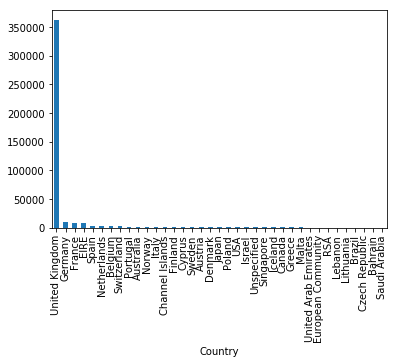

In [9]:
country_rank = df.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)
print(country_rank[:5])
country_rank.plot.bar()

-----

##### 구매 개수 데이터
- 예외 상황 : 환불의 경우, 구매 개수가 마이너스로 나타남.
- 본 예제에서는 예외 상황을 제외하고 분석을 진행

In [10]:
print(df['Quantity'].value_counts()[:15])

 1     73314
 12    60033
 2     58003
 6     37688
 4     32183
 3     26948
 24    23751
 10    21213
 8     11644
 5      8150
 48     5988
 25     4995
 20     4766
 16     3946
-1      3848
Name: Quantity, dtype: int64


In [11]:
print(len(df[df['Quantity'] < 0]))

8905


In [12]:
df = df[df['Quantity'] > 0]
print(df.shape)

(397924, 8)


-----

##### 상품 단가 분석

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64


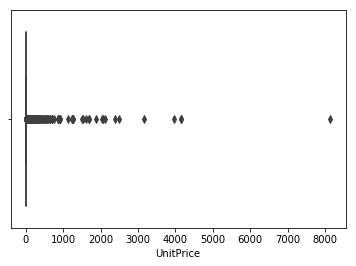

In [13]:
print(df['UnitPrice'].describe())
sns.boxplot(df['UnitPrice'])

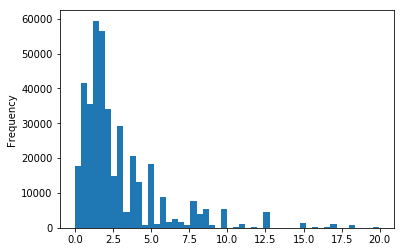

In [14]:
df[df['UnitPrice'] < 20]['UnitPrice'].plot(kind='hist', bins=50)

-----

### [유저 속성 추출]

##### 파생변수 추출

In [15]:
df['Amount'] = df['Quantity'] * df['UnitPrice']
df['YearMonDay'] = df['InvoiceDate'].apply(lambda x: str(x)[:10])
df['Year'] = pd.DatetimeIndex(df['InvoiceDate']).year
df['Mon'] = pd.DatetimeIndex(df['InvoiceDate']).month
df['Day'] = pd.DatetimeIndex(df['InvoiceDate']).day
df['Hour'] = pd.DatetimeIndex(df['InvoiceDate']).hour
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,YearMonDay,Year,Mon,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010,12,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010,12,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,1,8


-----

##### 유저별 주문 속성, 유저별 주문 아이템의 속성 추출

In [16]:
# 유저별 주문 횟수, 유저별 주문 아이템 개수

df['CustomerOrderCount'] = df.groupby('CustomerID')['InvoiceNo'].transform(lambda x: x.nunique())
df['CustomerItemCount'] = df.groupby('CustomerID')['StockCode'].transform(lambda x: x.nunique())

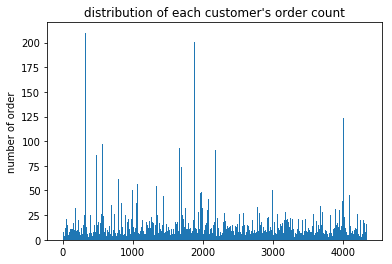

In [17]:
# 유저별 주문 횟수 그래프

orders = df.groupby('CustomerID')['CustomerOrderCount'].first()
plt.bar(range(len(orders)), orders.values, width=10)
plt.ylabel('number of order')
plt.title("distribution of each customer's order count")
plt.show()

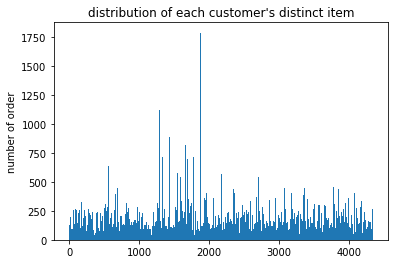

In [18]:
# 유저별 주문 아이템 개수 그래프

orders = df.groupby('CustomerID')['CustomerItemCount'].first()
plt.bar(range(len(orders)), orders.values, width=10)
plt.ylabel('number of order')
plt.title("distribution of each customer's distinct item")
plt.show()

In [19]:
# 유저별 총 주문액 합, 유저별 평균 주문액

df['CustomerTotalAmount'] = df.groupby('CustomerID')['Amount'].transform(lambda x: x.sum())
df['CustomerAverageAmount'] = df['CustomerTotalAmount'] / df['CustomerOrderCount']

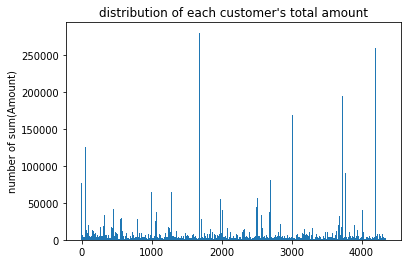

In [20]:
# 유저별 총 주문액 합 그래프

orders = df.groupby('CustomerID')['CustomerTotalAmount'].first()
plt.bar(range(len(orders)), orders.values, width=10)
plt.ylabel('number of sum(Amount)')
plt.title("distribution of each customer's total amount")
plt.show()

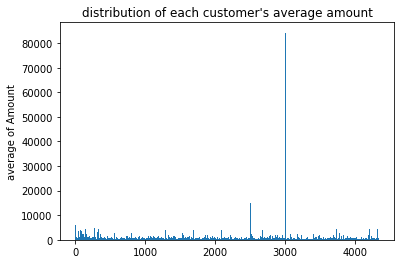

In [21]:
# 유저별 평균 주문액 그래프

orders = df.groupby('CustomerID')['CustomerAverageAmount'].first()
plt.bar(range(len(orders)), orders.values, width=10)
plt.ylabel('average of Amount')
plt.title("distribution of each customer's average amount")
plt.show()

count    397924.000000
mean        553.797599
std         744.905807
min           0.000000
25%         236.395000
50%         362.688182
75%         567.520000
max       84236.250000
Name: CustomerAverageAmount, dtype: float64


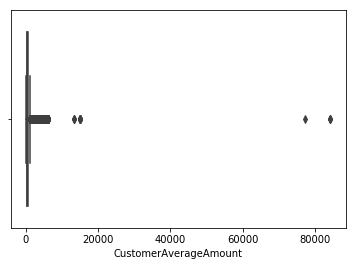

In [22]:
# 유저별 평균 주문액 상자그림

print(df['CustomerAverageAmount'].describe())
sns.boxplot(df['CustomerAverageAmount'])

-----

### [구매 날짜별 분석]

2010-12-01 08:26:00
2011-12-09 12:50:00


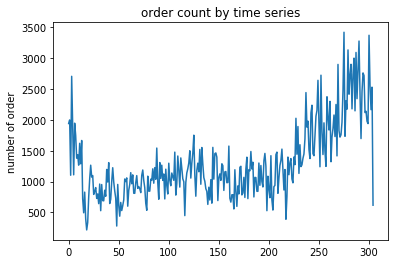

In [23]:
# 시계열 주문량 분석

print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())
orders = df.groupby(['Year', 'Mon', 'Day'])['InvoiceNo'].count()
plt.plot(range(len(orders)), orders.values)
plt.ylabel('number of order')
plt.title("order count by time series")
plt.show()

-----

##### 유저별 주문 날짜 관련 속성 분석

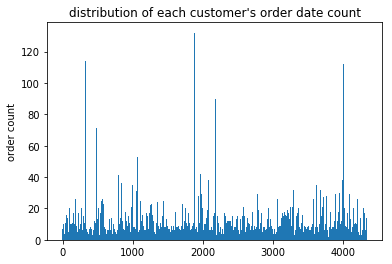

In [24]:
# 유저별 주문 날짜 개수

df['OrderDateCount'] = df.groupby('CustomerID')['YearMonDay'].transform(lambda x: x.nunique())
orders = df.groupby('CustomerID')['OrderDateCount'].first()
plt.bar(range(len(orders)), orders.values, width=10)
plt.ylabel('order count')
plt.title("distribution of each customer's order date count")
plt.show()

CustomerID
12346                                {2011-01-18 10:01:00}
12347    {2011-04-07 10:43:00, 2011-12-07 15:52:00, 201...
12348    {2010-12-16 19:09:00, 2011-04-05 10:47:00, 201...
12349                                {2011-11-21 09:51:00}
12350                                {2011-02-02 16:01:00}
12352    {2011-11-03 14:37:00, 2011-02-16 12:33:00, 201...
12353                                {2011-05-19 17:47:00}
12354                                {2011-04-21 13:11:00}
12355                                {2011-05-09 13:49:00}
12356    {2011-04-08 12:33:00, 2011-01-18 09:50:00, 201...
Name: InvoiceDate, dtype: object


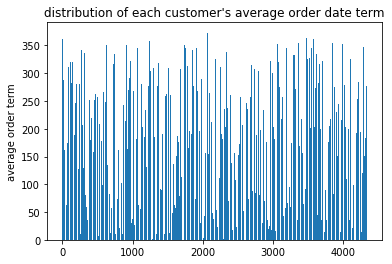

In [25]:
# 유저별 주문 시간의 개수 : 얼마나 많이 구매했는지
customer_order_date_set = df.groupby('CustomerID')['InvoiceDate'].apply(set)
print(customer_order_date_set[:10])

# 유저별 구매간 평균 Term : 얼마나 자주 구매하는지
cust_order_term_dict = {}
recent = df['InvoiceDate'].max()
for cust_no, date_set in customer_order_date_set.items():
    if len(date_set) == 1:
        date = date_set.pop()
        term = pd.Timedelta(recent - date).days
        cust_order_term_dict[cust_no] = term
    else:
        sorted_date_set = list(sorted(date_set))
        avg_term = 0
        prev_date = sorted_date_set[0]
        for date in sorted_date_set[1:]:
            term = pd.Timedelta(date - prev_date).days
            avg_term += term
            prev_date = date
        cust_order_term_dict[cust_no] = avg_term
df['AverageOrderDateTerm'] = df['CustomerID'].apply(lambda x: cust_order_term_dict[x])

# 유저별 구매간 평균 Term 그래프
orders = df.groupby('CustomerID')['AverageOrderDateTerm'].first()
plt.bar(range(len(orders)), orders.values)
plt.ylabel('average order term')
plt.title("distribution of each customer's average order date term")
plt.show()

-----

### [유저별 재구매 분석]

In [26]:
# 유저별 재구매 아이템 비율
def get_reorder_rate(x):
    customer_dict = x.value_counts()
    stock_len = len(customer_dict)
    reorder_stock_len = 0
    reorder_stock_len = len(customer_dict[customer_dict > 1])
    return reorder_stock_len/stock_len
df['CustomerReorderStockRate'] = df.groupby('CustomerID')['StockCode'].transform(lambda x: get_reorder_rate(x))

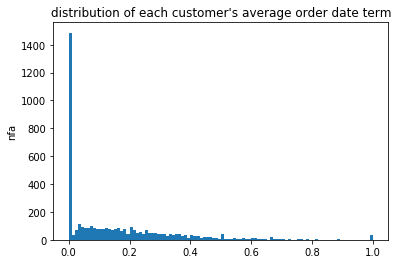

In [27]:
# 유저별 재구매 아이템 비율 그래프

orders = df.groupby('CustomerID')['CustomerReorderStockRate'].first()
plt.hist(orders.values, bins=100)
plt.ylabel('nfa')
plt.title("distribution of each customer's average order date term")
plt.show()

In [28]:
# 유저별 전체 구매 대비 재구매 비율

df = df.sort_values(['CustomerID', 'StockCode', 'InvoiceDate'])
df_shift = df.shift(1)
df['Reorder'] = np.where((df['StockCode'] == df_shift['StockCode']) & (df['CustomerID'] == df_shift['CustomerID']), 
                         1,0)
df['CustomerReorderTransactionRate'] = df.groupby('CustomerID')['Reorder'].transform(np.mean)

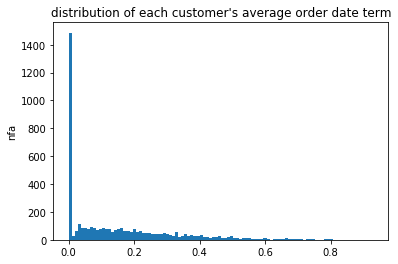

In [29]:
# 유저별 전체 구매 대비 재구매 비율 그래프

orders = df.groupby('CustomerID')['CustomerReorderTransactionRate'].first()
plt.hist(orders.values, bins=100)
plt.ylabel('nfa')
plt.title("distribution of each customer's average order date term")
plt.show()

-----

# <Step3. 분류> : 군집 분석

### [피처 스케일링]

In [30]:
customer_profile_df = df.copy()
customer_profile_df = customer_profile_df[['CustomerID', 'CustomerOrderCount',
                                           'CustomerItemCount',
                                           'CustomerTotalAmount', 'CustomerAverageAmount',
                                           'OrderDateCount', 'AverageOrderDateTerm', 
                                           'CustomerReorderStockRate', 'CustomerReorderTransactionRate']]
customer_profile_df = customer_profile_df.drop_duplicates('CustomerID')

In [31]:
def minmax_scaling(df, scale_columns):
    for col in scale_columns:
        series_min = df[col].min()
        series_max = df[col].max()
        df[col] = df[col].apply(lambda x: (x - series_min)/(series_max - series_min))
    return df

scale_columns = ['CustomerOrderCount',
                 'CustomerItemCount',
                 'CustomerTotalAmount', 'CustomerAverageAmount',
                 'OrderDateCount', 'AverageOrderDateTerm', 
                 'CustomerReorderStockRate', 'CustomerReorderTransactionRate']
scaled_customer_profile_df = minmax_scaling(customer_profile_df, scale_columns)
scaled_customer_profile_df.head()

,CustomerID,CustomerOrderCount,CustomerItemCount,CustomerTotalAmount,CustomerAverageAmount,OrderDateCount,AverageOrderDateTerm,CustomerReorderStockRate,CustomerReorderTransactionRate
61619,12346,0.000000,0.000000,0.275453,0.916275,0.000000,0.871314,0.000000,0.000000
148306,12347,0.028708,0.057111,0.015382,0.007309,0.045802,0.970509,0.417476,0.467093
34093,12348,0.014354,0.011758,0.006414,0.005334,0.022901,0.756032,0.318182,0.312412
485527,12349,0.000000,0.040314,0.006272,0.020865,0.000000,0.048257,0.000000,0.000000
80339,12350,0.000000,0.008959,0.001193,0.003970,0.000000,0.828418,0.000000,0.000000


-----

### [군집 분석] 

k: 1 | cost: 10.360142338330316
k: 2 | cost: 5.6843840821270275
k: 3 | cost: 3.93605240427797
k: 4 | cost: 2.7527802283602916
k: 5 | cost: 1.974780067986583
k: 6 | cost: 1.53032790739304
k: 7 | cost: 1.2046740308347201
k: 8 | cost: 1.017210913401579
k: 9 | cost: 0.8455433373757226


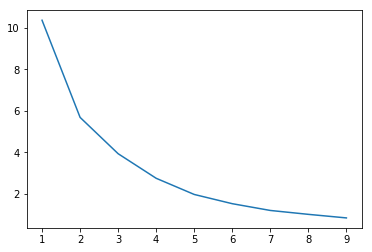

In [32]:
from sklearn.cluster import KMeans

X = scaled_customer_profile_df[['CustomerOrderCount', 'CustomerTotalAmount']]

k_list = []
cost_list = []
for k in range (1, 10):
    kmeans = KMeans(n_clusters=k).fit(X)
    interia = kmeans.inertia_
    print ("k:", k, "| cost:", interia)
    k_list.append(k)
    cost_list.append(interia)
    
plt.plot(k_list, cost_list)

In [33]:
# 적당한 k값을 선정 - 엘보우 메서드 (Elbow method)
kmeans = KMeans(n_clusters=4).fit(X)
cluster_num = kmeans.predict(X)
cluster = pd.Series(cluster_num)
scaled_customer_profile_df['cluster_num'] = cluster.values
scaled_customer_profile_df.head()

,CustomerID,CustomerOrderCount,CustomerItemCount,CustomerTotalAmount,CustomerAverageAmount,OrderDateCount,AverageOrderDateTerm,CustomerReorderStockRate,CustomerReorderTransactionRate,cluster_num
61619,12346,0.000000,0.000000,0.275453,0.916275,0.000000,0.871314,0.000000,0.000000,0
148306,12347,0.028708,0.057111,0.015382,0.007309,0.045802,0.970509,0.417476,0.467093,1
34093,12348,0.014354,0.011758,0.006414,0.005334,0.022901,0.756032,0.318182,0.312412,1
485527,12349,0.000000,0.040314,0.006272,0.020865,0.000000,0.048257,0.000000,0.000000,1
80339,12350,0.000000,0.008959,0.001193,0.003970,0.000000,0.828418,0.000000,0.000000,1


1    4058
0     267
2       8
3       6
Name: cluster_num, dtype: int64


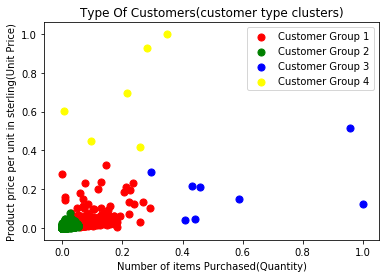

In [34]:
# 군집분석 결과 시각화
print(scaled_customer_profile_df['cluster_num'].value_counts())
plt.scatter(scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 0]['CustomerOrderCount'], 
            scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 0]['CustomerTotalAmount'], 
            s = 50, c = 'red', label = 'Customer Group 1')
plt.scatter(scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 1]['CustomerOrderCount'], 
            scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 1]['CustomerTotalAmount'], 
            s = 50, c = 'green', label = 'Customer Group 2')
plt.scatter(scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 2]['CustomerOrderCount'], 
            scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 2]['CustomerTotalAmount'], 
            s = 50, c = 'blue', label = 'Customer Group 3')
plt.scatter(scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 3]['CustomerOrderCount'], 
            scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 3]['CustomerTotalAmount'], 
            s = 50, c = 'yellow', label = 'Customer Group 4')
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('Number of items Purchased(Quantity)')
plt.ylabel('Product price per unit in sterling(Unit Price)')
plt.legend()
plt.show()

-----

### [다차원 군집 분석]

k: 1 | cost: 755.8047794098561
k: 2 | cost: 400.7303890376667
k: 3 | cost: 252.22911836678145
k: 4 | cost: 205.17486261388638
k: 5 | cost: 170.59637986021758
k: 6 | cost: 142.01282847017237
k: 7 | cost: 124.5415607721022
k: 8 | cost: 109.78379351421354
k: 9 | cost: 99.86294880563784
k: 10 | cost: 90.84081982717434
k: 11 | cost: 84.18965930307687
k: 12 | cost: 78.00918071438869
k: 13 | cost: 72.0246196485433
k: 14 | cost: 67.83288177739126
k: 15 | cost: 63.313081856081425
k: 16 | cost: 60.3875722465185
k: 17 | cost: 57.67422229345833
k: 18 | cost: 55.30983295197546
k: 19 | cost: 52.95871951885936


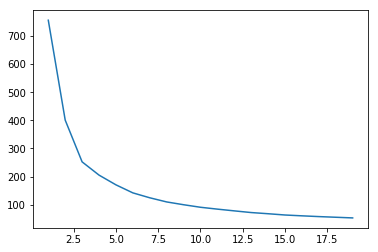

In [35]:
# 모든 피처를 선택했을 때의 군집 오차
scale_columns = ['CustomerOrderCount',
                 'CustomerItemCount',
                 'CustomerTotalAmount', 
                 'CustomerAverageAmount', 'OrderDateCount', 'AverageOrderDateTerm', 
                 'CustomerReorderStockRate', 'CustomerReorderTransactionRate']
X = scaled_customer_profile_df[scale_columns]
k_list = []
cost_list = []
for k in range (1, 20):
    kmeans = KMeans(n_clusters=k).fit(X)
    interia = kmeans.inertia_
    print ("k:", k, "| cost:", interia)
    k_list.append(k)
    cost_list.append(interia)
plt.plot(k_list, cost_list)

k: 1 | cost: 331.02592143634024
k: 2 | cost: 116.56322982697515
k: 3 | cost: 66.0330077542964
k: 4 | cost: 45.878644745786914
k: 5 | cost: 36.89092059333878
k: 6 | cost: 31.70160604683028
k: 7 | cost: 26.28381649289318
k: 8 | cost: 23.225274849888002
k: 9 | cost: 21.3083959704965
k: 10 | cost: 19.837181902044648
k: 11 | cost: 18.433960740415728
k: 12 | cost: 16.999726563898662
k: 13 | cost: 15.99492753214978
k: 14 | cost: 15.027718494045974
k: 15 | cost: 14.156869871908935
k: 16 | cost: 13.425418847191951
k: 17 | cost: 12.831891124670195
k: 18 | cost: 12.194523989331131
k: 19 | cost: 11.709217327619072


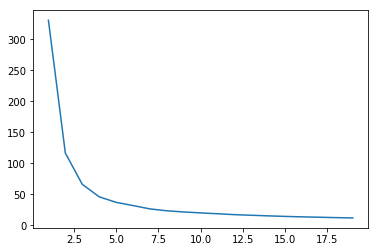

In [36]:
# 적당한 피처를 선택했을 때의 군집 오차
scale_columns = ['CustomerOrderCount',
                 'CustomerItemCount',
                 'CustomerTotalAmount', 
                 'CustomerReorderStockRate', 'CustomerReorderTransactionRate']
X = scaled_customer_profile_df[scale_columns]
k_list = []
cost_list = []
for k in range (1, 20):
    kmeans = KMeans(n_clusters=k).fit(X)
    interia = kmeans.inertia_
    print ("k:", k, "| cost:", interia)
    k_list.append(k)
    cost_list.append(interia)
plt.plot(k_list, cost_list)

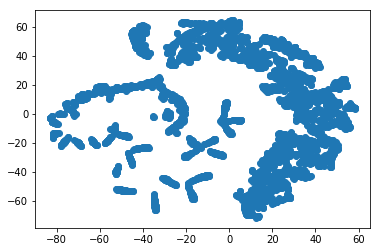

In [37]:
# 고차원 데이터 클러스터링을 2차원으로 시각화

from sklearn.manifold import TSNE

np.random.seed(600)
model = TSNE(learning_rate=300)
transformed = model.fit_transform(X)

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys)
plt.show()

In [38]:
kmeans = KMeans(n_clusters=4).fit(X)
cluster_num = kmeans.predict(X)
cluster = pd.Series(cluster_num)
scaled_customer_profile_df['multidimensional_cluster_num'] = cluster.values

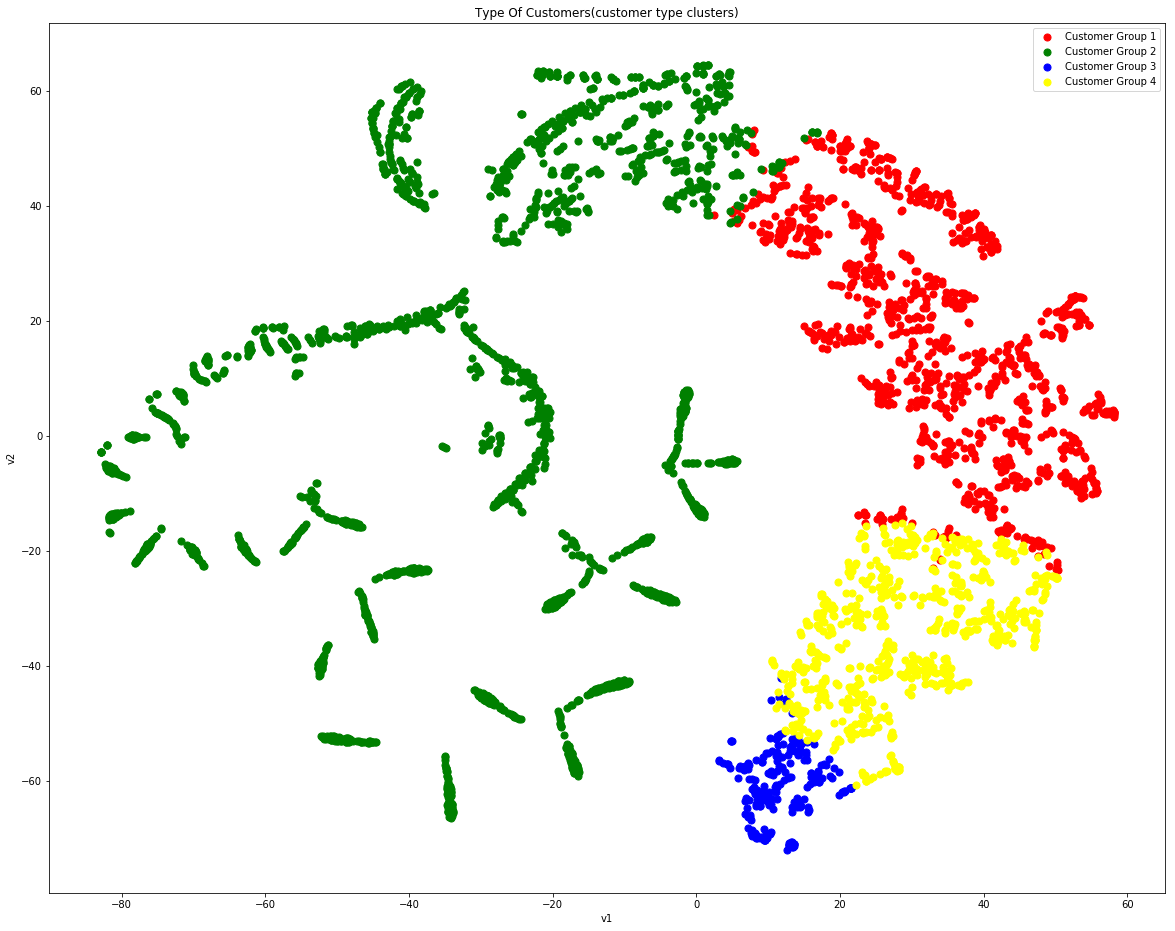

In [42]:
tsne_reduction_results = pd.DataFrame(transformed, columns=['v1', 'v2']).assign(cluster_num = scaled_customer_profile_df['multidimensional_cluster_num'].values)

plt.rcParams['figure.figsize'] = [20, 16]
plt.scatter(tsne_reduction_results[tsne_reduction_results['cluster_num'] == 0]['v1'], 
            tsne_reduction_results[tsne_reduction_results['cluster_num'] == 0]['v2'], 
            s = 50, c = 'red', label = 'Customer Group 1')
plt.scatter(tsne_reduction_results[tsne_reduction_results['cluster_num'] == 1]['v1'], 
            tsne_reduction_results[tsne_reduction_results['cluster_num'] == 1]['v2'], 
            s = 50, c = 'green', label = 'Customer Group 2')
plt.scatter(tsne_reduction_results[tsne_reduction_results['cluster_num'] == 2]['v1'], 
            tsne_reduction_results[tsne_reduction_results['cluster_num'] == 2]['v2'], 
            s = 50, c = 'blue', label = 'Customer Group 3')
plt.scatter(tsne_reduction_results[tsne_reduction_results['cluster_num'] == 3]['v1'], 
            tsne_reduction_results[tsne_reduction_results['cluster_num'] == 3]['v2'], 
            s = 50, c = 'yellow', label = 'Customer Group 4')
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('v1')
plt.ylabel('v2')
plt.legend()
plt.show()

-----

# <Step4. 활용> : 군집별 인기상품 추출하기

### [군집별 인기 상품]

In [43]:
scaled_customer_profile_df[['CustomerID', 'cluster_num', 'multidimensional_cluster_num']].head()

,CustomerID,cluster_num,multidimensional_cluster_num
61619,12346,0,1
148306,12347,1,3
34093,12348,1,3
485527,12349,1,1
80339,12350,1,1


In [45]:
df = pd.read_csv("../data/online_retail.csv", dtype={'CustomerID': str,'InvoiceID': str}, encoding="ISO-8859-1")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M")
df = df.merge(scaled_customer_profile_df[['CustomerID', 'cluster_num', 'multidimensional_cluster_num']], 
              on=['CustomerID'], how='left')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cluster_num,multidimensional_cluster_num
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,2.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,2.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,2.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,2.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,2.0


In [47]:
for cluster in range(0,4):
    top_10 = df[df['multidimensional_cluster_num']==cluster]['Description'].value_counts()
    print("cluster", str(cluster+1))
    print(top_10[:10])
    print("------\n")

cluster 1
WHITE HANGING HEART T-LIGHT HOLDER    557
REGENCY CAKESTAND 3 TIER              515
ASSORTED COLOUR BIRD ORNAMENT         441
PARTY BUNTING                         391
POSTAGE                               387
JUMBO BAG RED RETROSPOT               384
REX CASH+CARRY JUMBO SHOPPER          368
PAPER CHAIN KIT 50'S CHRISTMAS        335
SET OF 3 CAKE TINS PANTRY DESIGN      334
BAKING SET 9 PIECE RETROSPOT          310
Name: Description, dtype: int64
------

cluster 2
REGENCY CAKESTAND 3 TIER              380
WHITE HANGING HEART T-LIGHT HOLDER    320
ASSORTED COLOUR BIRD ORNAMENT         269
PARTY BUNTING                         256
SET OF 3 CAKE TINS PANTRY DESIGN      246
BAKING SET 9 PIECE RETROSPOT          229
JAM MAKING SET WITH JARS              226
POSTAGE                               219
PAPER CHAIN KIT 50'S CHRISTMAS        203
NATURAL SLATE HEART CHALKBOARD        197
Name: Description, dtype: int64
------

cluster 3
JUMBO BAG RED RETROSPOT               466
LUNCH BA

In [48]:
for cluster in range(0,4):
    top_10 = df[df['cluster_num']==cluster]['Description'].value_counts()
    print("cluster", str(cluster+1))
    print(top_10[:10])
    print("------\n")

cluster 1
JUMBO BAG RED RETROSPOT               623
WHITE HANGING HEART T-LIGHT HOLDER    557
REGENCY CAKESTAND 3 TIER              544
LUNCH BAG RED RETROSPOT               476
PARTY BUNTING                         432
JUMBO BAG PINK POLKADOT               361
ASSORTED COLOUR BIRD ORNAMENT         344
SET OF 3 CAKE TINS PANTRY DESIGN      343
LUNCH BAG  BLACK SKULL.               340
ALARM CLOCK BAKELIKE RED              330
Name: Description, dtype: int64
------

cluster 2
WHITE HANGING HEART T-LIGHT HOLDER    1419
REGENCY CAKESTAND 3 TIER              1237
ASSORTED COLOUR BIRD ORNAMENT         1033
JUMBO BAG RED RETROSPOT                917
PARTY BUNTING                          915
POSTAGE                                889
SET OF 3 CAKE TINS PANTRY DESIGN       814
REX CASH+CARRY JUMBO SHOPPER           793
LUNCH BAG RED RETROSPOT                787
PAPER CHAIN KIT 50'S CHRISTMAS         757
Name: Description, dtype: int64
------

cluster 3
JUMBO BAG RED RETROSPOT               99

-----

### `한걸음 더 나아가기`
- `텍스트 분석 미리 맛보기` 

### [텍스트 분석 미리 맛보기]

In [103]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

def wordcloud_cluster_show(df, cluster_col):
    stopwords = set(STOPWORDS)
    fig = plt.figure()
    for i in range(0,4):
        ax = fig.add_subplot(2, 2, i+1)
        wordcloud = WordCloud(
                              background_color='white',
                              stopwords=stopwords,
                              max_words=50,
                              max_font_size=50,
                              random_state=42
                             ).generate(str(df[df[cluster_col]==i]['Description']))
        ax.imshow(wordcloud)
        ax.axis('off')
        ax.set_title("cluster : " + str(i+1))
    plt.show()

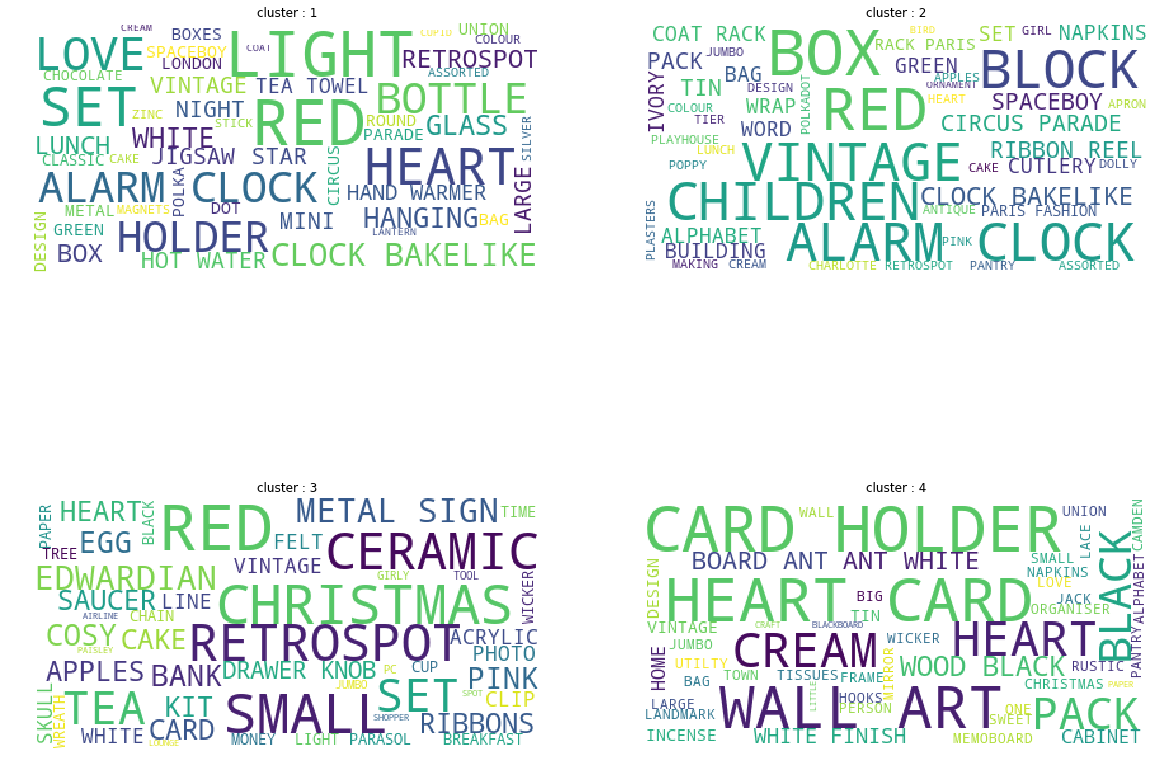

In [104]:
wordcloud_cluster_show(df, 'cluster_num')

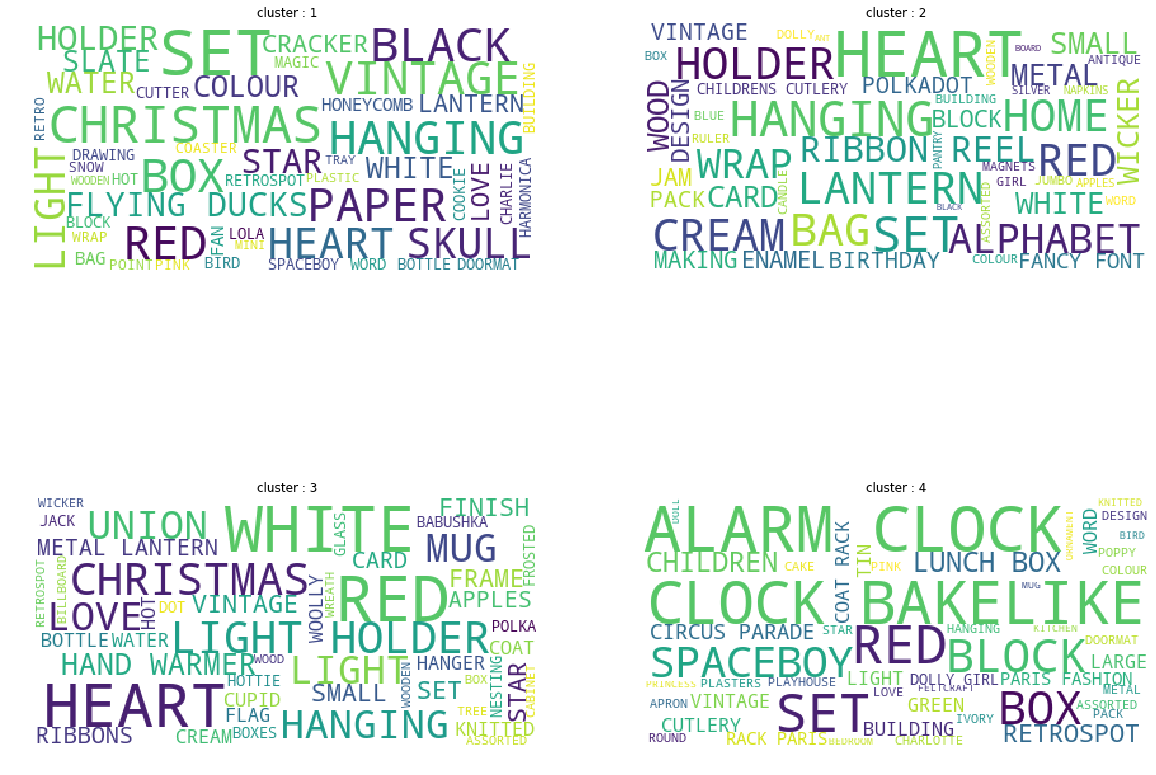

In [105]:
wordcloud_cluster_show(df, 'multidimensional_cluster_num')